In [1]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

Automatically created module for IPython interactive environment


In [24]:
raw_fnames = ['data/S001R06.edf',
              'data/S001R10.edf',
              'data/S001R14.edf']

raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

ch_name_dict = {}

for i in range(0, 64):
    ch_name_dict[i] = raw.ch_names[i]

name_ch_dict = {}
for idx, i in enumerate(raw.ch_names):
    name_ch_dict[i] = idx

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [95]:
def get_score_on_chanells(channels, name_ch_dict):
    ch_number_0 = [name_ch_dict[i] for i in channels]
    
    tmin, tmax = -1., 4.
    event_id = dict(hands=2, feet=3)
    subject = 1
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    raw_fnames = ['data/S001R06.edf',
                  'data/S001R10.edf',
                  'data/S001R14.edf']
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames], verbose=0)
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage, verbose=0)

    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=0)

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3), verbose=0)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True, verbose=0)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2
    
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    ep_data = []
    ep_data_train = []
    
    
    for i in range(len(epochs_data)):
        ep_data.append(epochs_data[i][ch_number_0, :])
        
    for i in range(len(epochs_data_train)):
        ep_data_train.append(epochs_data_train[i][ch_number_0, :])
        
    epochs_data = np.array(ep_data)
    epochs_data_train = np.array(ep_data_train)
    
    print(epochs_data.shape)
    print(epochs_data_train.shape)
        
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                              class_balance))

    # plot CSP patterns estimated on full data for visualization
    csp.fit_transform(epochs_data, labels)
    

    #csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
    
    
    sfreq = raw.info['sfreq']
    w_length = int(sfreq * 0.5)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]

        X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
        X_test = csp.transform(epochs_data_train[test_idx])

        # fit classifier
        lda.fit(X_train, y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
            score_this_window.append(lda.score(X_test, y_test))
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

    plt.figure()
    plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
    plt.axvline(0, linestyle='--', color='k', label='Onset')
    plt.axhline(0.5, linestyle='-', color='k', label='Chance')
    plt.xlabel('time (s)')
    plt.ylabel('classification accuracy')
    plt.title('Classification score over time')
    plt.legend(loc='lower right')
    plt.show()
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                              class_balance))

best channels:
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Es

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 3 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e

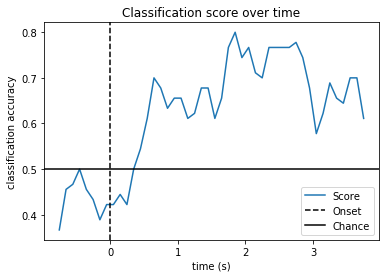

Classification accuracy: 0.677778 / Chance level: 0.533333
other channels:
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 3 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-0

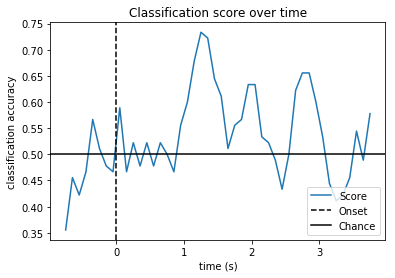

Classification accuracy: 0.666667 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 3 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-0

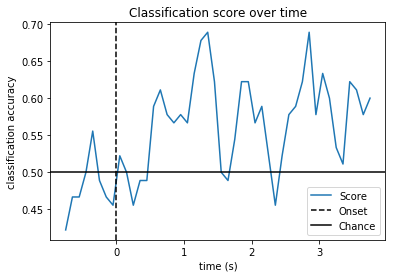

Classification accuracy: 0.655556 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 3 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e

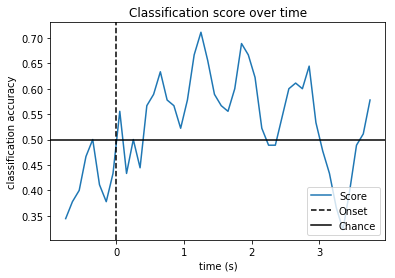

Classification accuracy: 0.711111 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 

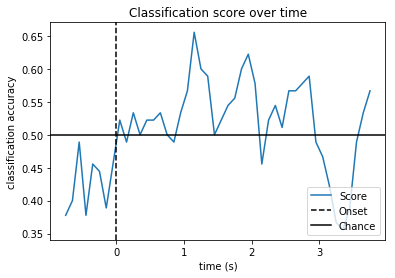

Classification accuracy: 0.600000 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 3 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e

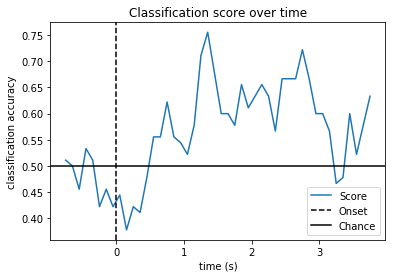

Classification accuracy: 0.722222 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 

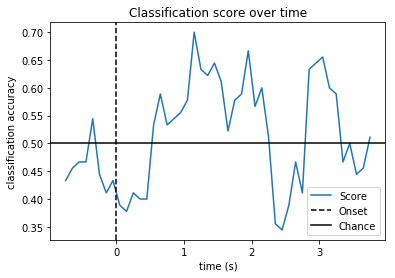

Classification accuracy: 0.611111 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 3 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e

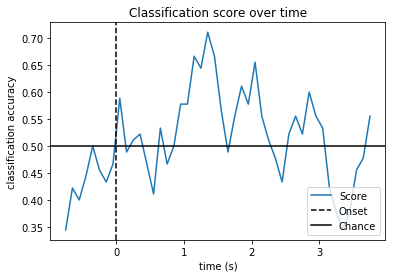

Classification accuracy: 0.644444 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 pr

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-0

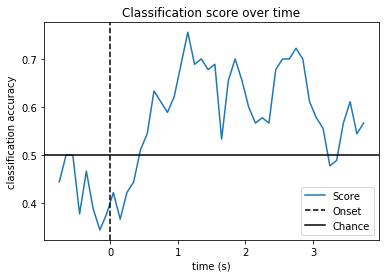

Classification accuracy: 0.677778 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 pr

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e

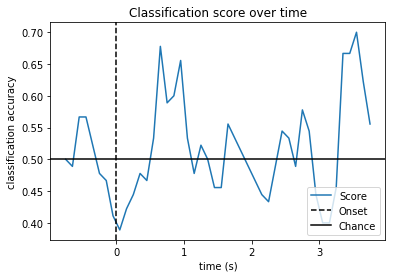

Classification accuracy: 0.533333 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 9.7e-07 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-0

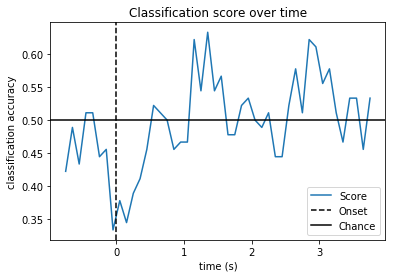

Classification accuracy: 0.577778 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 pr

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 3 dim * 2.4e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 3 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e

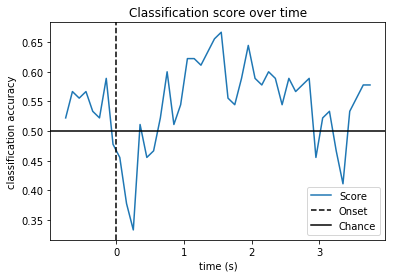

Classification accuracy: 0.588889 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 9.8e-07 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-0

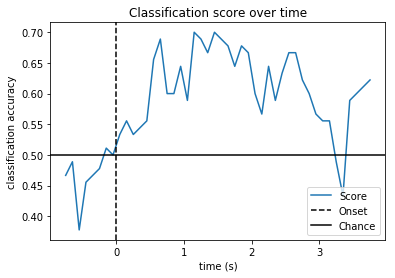

Classification accuracy: 0.644444 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 

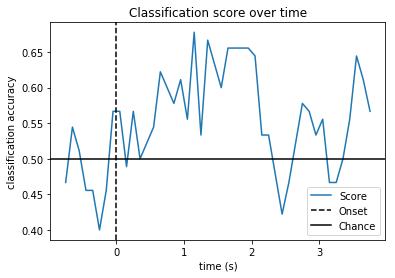

Classification accuracy: 0.688889 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 3 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e

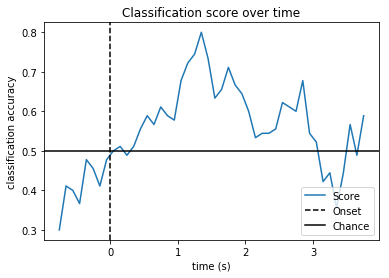

Classification accuracy: 0.811111 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 

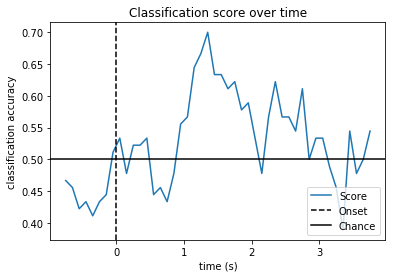

Classification accuracy: 0.611111 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 9.4e-07 (2.2e-16 eps * 3 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.5e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 

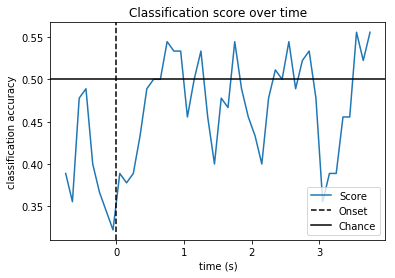

Classification accuracy: 0.466667 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-0

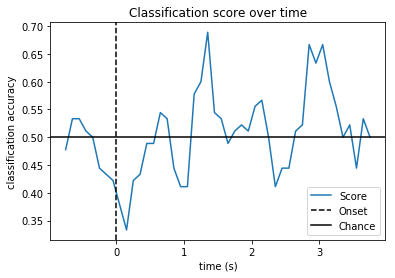

Classification accuracy: 0.622222 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 9.7e-07 (2.2e-16 eps * 3 dim * 1.4e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-0

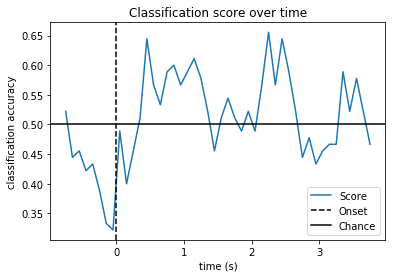

Classification accuracy: 0.511111 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 3 dim * 1.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 pr

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e

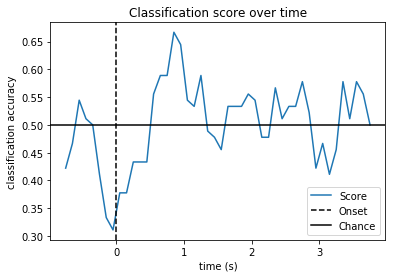

Classification accuracy: 0.588889 / Chance level: 0.533333
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 3 dim * 2.1e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 

Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 3 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 3 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-0

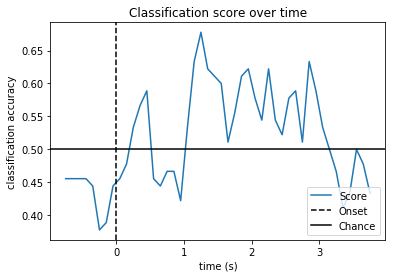

Classification accuracy: 0.611111 / Chance level: 0.533333



In [98]:
import random
channel_names_BEST = ['O2', 'C3', 'C4']
dont_best = [i for i in list(name_ch_dict.keys()) if i not in channel_names_BEST]
dont_best = [i for i in dont_best if i[0] != 'C' and i[0] != 'T' and i[:2] != 'FC']
print('best channels:')
get_score_on_chanells(channel_names_BEST, name_ch_dict)
print('other channels:')
for _ in range(20):
    channels = random.sample(dont_best, len(channel_names_BEST))
    get_score_on_chanells(channels, name_ch_dict)
    
print()

In [93]:
def get_score_on_chanells(channels, name_ch_dict):
    ch_number_0 = [name_ch_dict[i] for i in channels]
    
    tmin, tmax = -1., 4.
    event_id = dict(hands=2, feet=3)
    subject = 1
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    raw_fnames = ['data/S001R06.edf',
                  'data/S001R10.edf',
                  'data/S001R14.edf']
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames], verbose=0)
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage, verbose=0)

    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=0)

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3), verbose=0)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True, verbose=0)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2
    
    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    ep_data = []
    ep_data_train = []
    
    
    for i in range(len(epochs_data)):
        ep_data.append(epochs_data[i][ch_number_0, :])
        
    for i in range(len(epochs_data_train)):
        ep_data_train.append(epochs_data_train[i][ch_number_0, :])
        
    epochs_data = np.array(ep_data)
    epochs_data_train = np.array(ep_data_train)
    
    print(epochs_data.shape)
    print(epochs_data_train.shape)
        
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                              class_balance))

    # plot CSP patterns estimated on full data for visualization
    csp.fit_transform(epochs_data, labels)
    

    #csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
    
    
    sfreq = raw.info['sfreq']
    w_length = int(sfreq * 0.5)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]

        X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
        X_test = csp.transform(epochs_data_train[test_idx])

        # fit classifier
        lda.fit(X_train, y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
            score_this_window.append(lda.score(X_test, y_test))
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

    plt.figure()
    plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
    plt.axvline(0, linestyle='--', color='k', label='Onset')
    plt.axhline(0.5, linestyle='-', color='k', label='Chance')
    plt.xlabel('time (s)')
    plt.ylabel('classification accuracy')
    plt.title('Classification score over time')
    plt.legend(loc='lower right')
    plt.show()
    print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                              class_balance))

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
(45, 3, 801)
(45, 3, 161)
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covari

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 3 dim * 2.2e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-06 (2.2e-16 eps * 3 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 3 dim * 2e+0

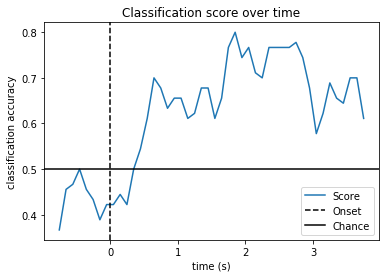

Classification accuracy: 0.677778 / Chance level: 0.533333


In [94]:
channel_names_BEST = ['O2', 'C3', 'C4']

get_score_on_chanells(channel_names_BEST, name_ch_dict)

In [59]:
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = ['data/S001R06.edf',
              'data/S001R10.edf',
              'data/S001R14.edf']
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/alexandr/Documents/Git/MIPT_Masters_work/data/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple a

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [67]:
raw.

['eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg',
 'eeg']

In [58]:


events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

AttributeError: 'numpy.ndarray' object has no attribute 'annotations'

In [30]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

In [68]:
ep_data = []

for i in range(len(ep_data)):
    ep_data.append

ep_data.append(epochs_data[0])
ep_data.append(epochs_data[1])

In [72]:
np.array(ep_data).shape

(2, 64, 801)

In [50]:
epochs_data[0] = np.delete(epochs_data[0], 0, axis=0)

ValueError: could not broadcast input array from shape (63,801) into shape (64,801)

In [15]:
[1,2,3,4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

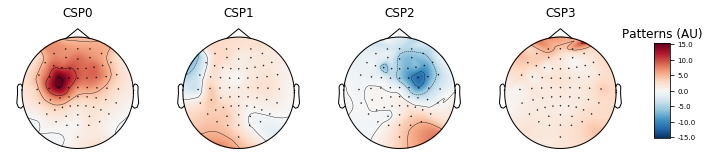

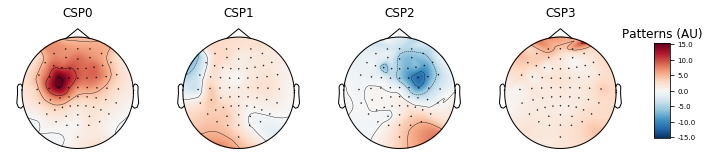

In [3]:

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

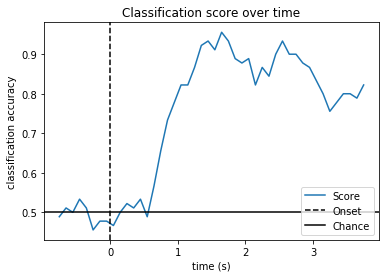

In [5]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()